walmart 주단위 데이터 139주로 향후 4주 예측하기

In [253]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime  
columns=['date','sales']
txs=pd.read_table('./lstmData/lstmPrac11.csv', sep=',',header=None,names=columns )
tf.reset_default_graph()

In [254]:
txs

,date,sales
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90
5,2010-03-12,21043.39
6,2010-03-19,22136.64
7,2010-03-26,26229.21
8,2010-04-02,57258.43
9,2010-04-09,42960.91


In [255]:
def noOutlierSales(sales):
    mean=np.mean(sales)
    std=np.std(sales)
    for i in range(len(sales)):
        if (sales[i]<mean-2*std or sales[i]>mean+2*std):
             sales[i]=int(mean)
    return sales
def logSales(sales):
    for i in range(len(sales)):
        if sales[i] is 0:
            sales[i]=1
    return np.log(sales)
def sqrtSales(sales):
    return np.sqrt(sales)


def rmse(a,b):
    sum=0
    for i in range(len(a)):
        sum=sum+(a[i]-b[i])**2
    return np.sqrt(sum/len(a))

def minMaxNormalizer(data):
    numerator=data-np.min(data)
    denominator=np.max(data)-np.min(data)
    return numerator/(denominator+1e-7)

def minMaxDeNormalizer(data, originalData):
    shift=np.min(originalData)
    multiplier=np.max(originalData)-np.min(originalData)
    return (data+shift)*multiplier


In [256]:
def LSTM(txs, forecastDay, features):
    tf.set_random_seed(7)
    #Add basic date related features to the table
    year = lambda x: datetime.strptime(x, "%Y-%m-%d").year
    dayOfWeek = lambda x: datetime.strptime(x, "%Y-%m-%d").weekday()
    month = lambda x: datetime.strptime(x, "%Y-%m-%d").month
    weekNumber = lambda x: datetime.strptime(x, "%Y-%m-%d").strftime('%V')
    txs['year'] = txs['date'].map(year)
    txs['month'] = txs['date'].map(month)
    txs['weekNumber'] = txs['date'].map(weekNumber)
    txs['dayOfWeek'] = txs['date'].map(dayOfWeek)

    #Add non-basic date related features to the table
    seasons = [0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 0]  # dec - feb is winter, then spring, summer, fall etc
    season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d").month - 1)]
    day_of_week01s = [0, 0, 0, 0, 0, 1, 1]
    day_of_week01 = lambda x: day_of_week01s[(datetime.strptime(x, "%Y-%m-%d").weekday())]
    txs['season'] = txs['date'].map(season)
    txs['dayOfWeek01'] = txs['date'].map(day_of_week01)

    #Backup originalSales
    originalSales = list(txs['sales'])
    sales = list(txs['sales'])

    if features is 'DayOfWeek_WeekNumber_Month_Season' :
        tempxy = [list(txs['dayOfWeek']), list(txs['weekNumber']),list(txs['month']),list(txs['season']) , sales]
    elif features is'DayOfWeek01_WeekNumber_Month_Season' :
        tempxy = [list(txs['dayOfWeek01']), list(txs['weekNumber']),list(txs['month']),list(txs['season']) , sales]

    elif features is 'WeekNumber_Month_Season_Year' :
        tempxy = [list(txs['weekNumber']), list(txs['month']), list(txs['season']),list(txs['year']), sales]

    xy = np.array(tempxy).transpose().astype(np.float)

    #Backup originalXY for denormalize
    originalXY = np.array(tempxy).transpose().astype(np.float)
    xy = minMaxNormalizer(xy)

    #TRAIN PARAMETERS
    # data_dim은 y값 도출을 위한 feature 가지수+1(독립변수 가지수 +1(y포함))
    data_dim = 5
    # data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
    seq_length = 10
    # output_dim(=forecastDays)만큼의 다음날 y_data를 예측
    output_dim = forecastDay
    # hidden_dim은 정말 임의로 설정
    hidden_dim = 100
    # learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
    learning_rate = 0.0005

    # Build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
    x = xy
    y = xy[:, [-1]]
    dataX = []
    dataY = []
    for i in range(0, len(y) - seq_length - forecastDay+1):
        _x = x[i:i + seq_length]
        _y = y[i + seq_length:i + seq_length + forecastDay]
        _y = np.reshape(_y, (forecastDay))
        print(_x,"->",_y)
        dataX.append(_x)
        dataY.append(_y)
    print('data set length:',len(y) - seq_length - forecastDay+1)
    
    train_size = int(len(dataY)-forecastDay)
    train_size = int(len(dataY)*0.7)    
    test_size = len(dataY) - train_size
    print('train size:' , train_size)
    print('test size:' , test_size)
    trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
    print('trainX:', trainX)
    print('testX:', testX)
    trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])

    X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
    Y = tf.placeholder(tf.float32, [None, forecastDay])

    cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
    outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)
    loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(loss)
    
    denormalizedTestY=originalSales[train_size+seq_length:]
#     denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])
    
    targets = tf.placeholder(tf.float32, [None, 1])
    predictions = tf.placeholder(tf.float32, [None, 1])
    
    count=0
    with tf.Session() as sess:

        # 초기화
        init = tf.global_variables_initializer()
        sess.run(init)

        # Training step
        while(1):
            count=count+1
            _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
            print("[step: {}] loss: {}".format(count, step_loss))
            if(step_loss<0.5):
                break

        # Test step
        # test_predict= sess.run(Y_pred, feed_dict={X: testX}
        test_predict = minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalXY)
        realSale= minMaxDeNormalizer(testY[-1],originalXY)
        # Plot predictions
#         plt.plot(denormalizedTestY_feed)
        plt.plot(realSale)      #실제 sales 파란색
        plt.plot(test_predict[-1]) #예측 sales 주황색
               
        plt.xlabel("Time Period")
        plt.ylabel("Stock Price")
        plt.show()
        
    return test_predict[-1]




[[  8.68174327e-05   3.47269731e-05   0.00000000e+00   3.49006079e-02
    4.32776220e-01]
 [  1.04180919e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    7.99406065e-01]
 [  1.21544406e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    7.22243772e-01]
 [  1.38907892e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    3.36913105e-01]
 [  1.56271379e-04   5.20904596e-05   1.73634865e-05   3.49006079e-02
    3.79008448e-01]
 [  1.73634865e-04   5.20904596e-05   1.73634865e-05   3.49006079e-02
    3.65386619e-01]
 [  1.90998352e-04   5.20904596e-05   1.73634865e-05   3.49006079e-02
    3.84369251e-01]
 [  2.08361838e-04   5.20904596e-05   1.73634865e-05   3.49006079e-02
    4.55430535e-01]
 [  2.25725325e-04   6.94539461e-05   1.73634865e-05   3.49006079e-02
    9.94205978e-01]
 [  2.43088811e-04   6.94539461e-05   1.73634865e-05   3.49006079e-02
    7.45951182e-01]] -> [ 0.30554458  0.28033957  0.28745443  0.30236671]
[[  1.04180919e-04   3.47269731e-05   0.000000

[[  6.07722029e-04   1.56271379e-04   5.20904596e-05   3.49006079e-02
    2.82013928e-01]
 [  6.25085515e-04   1.56271379e-04   5.20904596e-05   3.49006079e-02
    3.15924123e-01]
 [  6.42449002e-04   1.56271379e-04   5.20904596e-05   3.49006079e-02
    3.36056912e-01]
 [  6.59812488e-04   1.56271379e-04   5.20904596e-05   3.49006079e-02
    3.14670132e-01]
 [  6.77175975e-04   1.73634865e-04   5.20904596e-05   3.49006079e-02
    3.48905197e-01]
 [  6.94539461e-04   1.73634865e-04   5.20904596e-05   3.49006079e-02
    4.06097744e-01]
 [  7.11902948e-04   1.73634865e-04   5.20904596e-05   3.49006079e-02
    4.68438043e-01]
 [  7.29266434e-04   1.73634865e-04   5.20904596e-05   3.49006079e-02
    4.43516231e-01]
 [  7.46629921e-04   1.73634865e-04   5.20904596e-05   3.49006079e-02
    6.70941268e-01]
 [  7.63993407e-04   1.90998352e-04   5.20904596e-05   3.49006079e-02
    5.94506332e-01]] -> [ 0.33944557  0.33950547  0.32678585  0.39098335]
[[  6.25085515e-04   1.56271379e-04   5.209045

    3.18140225e-01]] -> [ 0.34060597  0.33427316  0.32900004  0.38033797]
[[  4.86177623e-04   1.21544406e-04   3.47269731e-05   3.49353349e-02
    2.87646643e-01]
 [  5.03541109e-04   1.21544406e-04   3.47269731e-05   3.49353349e-02
    2.83859320e-01]
 [  5.20904596e-04   1.21544406e-04   3.47269731e-05   3.49353349e-02
    2.73148132e-01]
 [  5.38268083e-04   1.38907892e-04   3.47269731e-05   3.49353349e-02
    2.88725437e-01]
 [  5.55631569e-04   1.38907892e-04   3.47269731e-05   3.49353349e-02
    2.79898014e-01]
 [  5.72995056e-04   1.38907892e-04   3.47269731e-05   3.49353349e-02
    3.00921376e-01]
 [  5.90358542e-04   1.38907892e-04   3.47269731e-05   3.49353349e-02
    2.82788687e-01]
 [  6.07722029e-04   1.38907892e-04   3.47269731e-05   3.49353349e-02
    2.89627123e-01]
 [  6.25085515e-04   1.56271379e-04   5.20904596e-05   3.49353349e-02
    3.18140225e-01]
 [  6.42449002e-04   1.56271379e-04   5.20904596e-05   3.49353349e-02
    3.40605972e-01]] -> [ 0.33427316  0.329000

[step: 12] loss: 30.49114990234375
[step: 13] loss: 28.18830680847168
[step: 14] loss: 25.915508270263672
[step: 15] loss: 23.683509826660156
[step: 16] loss: 21.508684158325195
[step: 17] loss: 19.414392471313477
[step: 18] loss: 17.432525634765625
[step: 19] loss: 15.604827880859375
[step: 20] loss: 13.983329772949219
[step: 21] loss: 12.628467559814453
[step: 22] loss: 11.602334976196289
[step: 23] loss: 10.953788757324219
[step: 24] loss: 10.694160461425781
[step: 25] loss: 10.770895004272461
[step: 26] loss: 11.058647155761719
[step: 27] loss: 11.387922286987305
[step: 28] loss: 11.604463577270508
[step: 29] loss: 11.6224365234375
[step: 30] loss: 11.440160751342773
[step: 31] loss: 11.118624687194824
[step: 32] loss: 10.744306564331055
[step: 33] loss: 10.39645004272461
[step: 34] loss: 10.12800121307373
[step: 35] loss: 9.960592269897461
[step: 36] loss: 9.889406204223633
[step: 37] loss: 9.892690658569336
[step: 38] loss: 9.941688537597656
[step: 39] loss: 10.008307456970215
[s

[step: 247] loss: 8.902315139770508
[step: 248] loss: 8.898508071899414
[step: 249] loss: 8.894658088684082
[step: 250] loss: 8.890768051147461
[step: 251] loss: 8.886835098266602
[step: 252] loss: 8.882856369018555
[step: 253] loss: 8.87883472442627
[step: 254] loss: 8.874763488769531
[step: 255] loss: 8.870643615722656
[step: 256] loss: 8.866475105285645
[step: 257] loss: 8.86225414276123
[step: 258] loss: 8.857983589172363
[step: 259] loss: 8.853656768798828
[step: 260] loss: 8.849276542663574
[step: 261] loss: 8.844839096069336
[step: 262] loss: 8.840341567993164
[step: 263] loss: 8.835785865783691
[step: 264] loss: 8.831169128417969
[step: 265] loss: 8.826488494873047
[step: 266] loss: 8.821747779846191
[step: 267] loss: 8.816938400268555
[step: 268] loss: 8.812061309814453
[step: 269] loss: 8.807114601135254
[step: 270] loss: 8.80209732055664
[step: 271] loss: 8.797008514404297
[step: 272] loss: 8.791845321655273
[step: 273] loss: 8.786605834960938
[step: 274] loss: 8.78129005432

[step: 485] loss: 7.479636192321777
[step: 486] loss: 7.4750800132751465
[step: 487] loss: 7.470546245574951
[step: 488] loss: 7.466031551361084
[step: 489] loss: 7.4615373611450195
[step: 490] loss: 7.457067489624023
[step: 491] loss: 7.452618598937988
[step: 492] loss: 7.448190212249756
[step: 493] loss: 7.443787574768066
[step: 494] loss: 7.439405918121338
[step: 495] loss: 7.4350481033325195
[step: 496] loss: 7.430717945098877
[step: 497] loss: 7.426415920257568
[step: 498] loss: 7.4221601486206055
[step: 499] loss: 7.418043613433838
[step: 500] loss: 7.414471626281738
[step: 501] loss: 7.41279411315918
[step: 502] loss: 7.415204048156738
[step: 503] loss: 7.417263031005859
[step: 504] loss: 7.407046318054199
[step: 505] loss: 7.395488739013672
[step: 506] loss: 7.3966779708862305
[step: 507] loss: 7.395760536193848
[step: 508] loss: 7.386667251586914
[step: 509] loss: 7.383274555206299
[step: 510] loss: 7.382989883422852
[step: 511] loss: 7.3772358894348145
[step: 512] loss: 7.372

[step: 715] loss: 6.9316253662109375
[step: 716] loss: 6.92976188659668
[step: 717] loss: 6.928009033203125
[step: 718] loss: 6.926384925842285
[step: 719] loss: 6.925025463104248
[step: 720] loss: 6.92393684387207
[step: 721] loss: 6.923327445983887
[step: 722] loss: 6.922926902770996
[step: 723] loss: 6.922765731811523
[step: 724] loss: 6.921629428863525
[step: 725] loss: 6.919252395629883
[step: 726] loss: 6.914597034454346
[step: 727] loss: 6.909023284912109
[step: 728] loss: 6.903928756713867
[step: 729] loss: 6.900681495666504
[step: 730] loss: 6.89932918548584
[step: 731] loss: 6.8989763259887695
[step: 732] loss: 6.89856481552124
[step: 733] loss: 6.8970746994018555
[step: 734] loss: 6.894341945648193
[step: 735] loss: 6.890531539916992
[step: 736] loss: 6.8865838050842285
[step: 737] loss: 6.88321590423584
[step: 738] loss: 6.880759239196777
[step: 739] loss: 6.8790435791015625
[step: 740] loss: 6.877676486968994
[step: 741] loss: 6.876317501068115
[step: 742] loss: 6.87468338

[step: 951] loss: 6.169391632080078
[step: 952] loss: 6.1647467613220215
[step: 953] loss: 6.159949779510498
[step: 954] loss: 6.154706001281738
[step: 955] loss: 6.150424003601074
[step: 956] loss: 6.145472049713135
[step: 957] loss: 6.140046119689941
[step: 958] loss: 6.135617256164551
[step: 959] loss: 6.13215970993042
[step: 960] loss: 6.129850387573242
[step: 961] loss: 6.13275671005249
[step: 962] loss: 6.144247531890869
[step: 963] loss: 6.176509857177734
[step: 964] loss: 6.2335734367370605
[step: 965] loss: 6.337233543395996
[step: 966] loss: 6.3488311767578125
[step: 967] loss: 6.263952732086182
[step: 968] loss: 6.095915794372559
[step: 969] loss: 6.101349830627441
[step: 970] loss: 6.210907459259033
[step: 971] loss: 6.169643402099609
[step: 972] loss: 6.065134048461914
[step: 973] loss: 6.076781272888184
[step: 974] loss: 6.134651184082031
[step: 975] loss: 6.096651077270508
[step: 976] loss: 6.033594131469727
[step: 977] loss: 6.067593574523926
[step: 978] loss: 6.0932245

[step: 1175] loss: 5.1088409423828125
[step: 1176] loss: 5.104678153991699
[step: 1177] loss: 5.100470066070557
[step: 1178] loss: 5.096356391906738
[step: 1179] loss: 5.092148303985596
[step: 1180] loss: 5.088000297546387
[step: 1181] loss: 5.083828449249268
[step: 1182] loss: 5.079647541046143
[step: 1183] loss: 5.075489044189453
[step: 1184] loss: 5.071311950683594
[step: 1185] loss: 5.067122459411621
[step: 1186] loss: 5.0629730224609375
[step: 1187] loss: 5.058779716491699
[step: 1188] loss: 5.054599285125732
[step: 1189] loss: 5.050429344177246
[step: 1190] loss: 5.046241283416748
[step: 1191] loss: 5.042052268981934
[step: 1192] loss: 5.03787899017334
[step: 1193] loss: 5.0336761474609375
[step: 1194] loss: 5.029487609863281
[step: 1195] loss: 5.025296688079834
[step: 1196] loss: 5.0210957527160645
[step: 1197] loss: 5.016890525817871
[step: 1198] loss: 5.012696266174316
[step: 1199] loss: 5.008482933044434
[step: 1200] loss: 5.004271507263184
[step: 1201] loss: 5.00005722045898

[step: 1407] loss: 4.490490913391113
[step: 1408] loss: 4.472968101501465
[step: 1409] loss: 4.458083152770996
[step: 1410] loss: 4.466785430908203
[step: 1411] loss: 4.433769226074219
[step: 1412] loss: 4.454380512237549
[step: 1413] loss: 4.416603088378906
[step: 1414] loss: 4.440208435058594
[step: 1415] loss: 4.404745101928711
[step: 1416] loss: 4.426368713378906
[step: 1417] loss: 4.396136283874512
[step: 1418] loss: 4.408874034881592
[step: 1419] loss: 4.391486167907715
[step: 1420] loss: 4.3878936767578125
[step: 1421] loss: 4.388258934020996
[step: 1422] loss: 4.370110034942627
[step: 1423] loss: 4.381037712097168
[step: 1424] loss: 4.361132621765137
[step: 1425] loss: 4.368324279785156
[step: 1426] loss: 4.356086730957031
[step: 1427] loss: 4.3557047843933105
[step: 1428] loss: 4.34953498840332
[step: 1429] loss: 4.345486640930176
[step: 1430] loss: 4.342638969421387
[step: 1431] loss: 4.334951400756836
[step: 1432] loss: 4.336326599121094
[step: 1433] loss: 4.32585334777832
[

[step: 1631] loss: 3.78113055229187
[step: 1632] loss: 3.73714542388916
[step: 1633] loss: 3.8628268241882324
[step: 1634] loss: 3.7746946811676025
[step: 1635] loss: 3.7046563625335693
[step: 1636] loss: 3.8083322048187256
[step: 1637] loss: 3.7676429748535156
[step: 1638] loss: 3.686037063598633
[step: 1639] loss: 3.763441562652588
[step: 1640] loss: 3.7595267295837402
[step: 1641] loss: 3.6754119396209717
[step: 1642] loss: 3.716015338897705
[step: 1643] loss: 3.745725154876709
[step: 1644] loss: 3.677849292755127
[step: 1645] loss: 3.670858144760132
[step: 1646] loss: 3.7134194374084473
[step: 1647] loss: 3.685899496078491
[step: 1648] loss: 3.6477088928222656
[step: 1649] loss: 3.6667094230651855
[step: 1650] loss: 3.680504322052002
[step: 1651] loss: 3.6506540775299072
[step: 1652] loss: 3.6324939727783203
[step: 1653] loss: 3.6495001316070557
[step: 1654] loss: 3.6544575691223145
[step: 1655] loss: 3.630709648132324
[step: 1656] loss: 3.6176652908325195
[step: 1657] loss: 3.6267

[step: 1857] loss: 3.4543867111206055
[step: 1858] loss: 3.394047498703003
[step: 1859] loss: 3.1883938312530518
[step: 1860] loss: 3.0461673736572266
[step: 1861] loss: 3.0280075073242188
[step: 1862] loss: 3.117082118988037
[step: 1863] loss: 3.2544212341308594
[step: 1864] loss: 3.3277785778045654
[step: 1865] loss: 3.3798978328704834
[step: 1866] loss: 3.2711422443389893
[step: 1867] loss: 3.1423990726470947
[step: 1868] loss: 3.023846387863159
[step: 1869] loss: 3.012336254119873
[step: 1870] loss: 3.0839366912841797
[step: 1871] loss: 3.1406068801879883
[step: 1872] loss: 3.149329662322998
[step: 1873] loss: 3.085096836090088
[step: 1874] loss: 3.021836280822754
[step: 1875] loss: 2.9835011959075928
[step: 1876] loss: 2.9848084449768066
[step: 1877] loss: 3.0149154663085938
[step: 1878] loss: 3.0488080978393555
[step: 1879] loss: 3.0757265090942383
[step: 1880] loss: 3.0691351890563965
[step: 1881] loss: 3.04972243309021
[step: 1882] loss: 3.0110349655151367
[step: 1883] loss: 2.

[step: 2077] loss: 2.6058688163757324
[step: 2078] loss: 2.610403537750244
[step: 2079] loss: 2.7415144443511963
[step: 2080] loss: 2.729495048522949
[step: 2081] loss: 2.5793111324310303
[step: 2082] loss: 2.571868419647217
[step: 2083] loss: 2.674288749694824
[step: 2084] loss: 2.6745033264160156
[step: 2085] loss: 2.5950183868408203
[step: 2086] loss: 2.5456106662750244
[step: 2087] loss: 2.573526382446289
[step: 2088] loss: 2.6108217239379883
[step: 2089] loss: 2.5875349044799805
[step: 2090] loss: 2.5496702194213867
[step: 2091] loss: 2.5433125495910645
[step: 2092] loss: 2.554080009460449
[step: 2093] loss: 2.553328037261963
[step: 2094] loss: 2.543229341506958
[step: 2095] loss: 2.545602321624756
[step: 2096] loss: 2.5471725463867188
[step: 2097] loss: 2.5302047729492188
[step: 2098] loss: 2.5080184936523438
[step: 2099] loss: 2.502302646636963
[step: 2100] loss: 2.516528367996216
[step: 2101] loss: 2.527013063430786
[step: 2102] loss: 2.515763282775879
[step: 2103] loss: 2.4988

[step: 2302] loss: 2.1950955390930176
[step: 2303] loss: 2.1542487144470215
[step: 2304] loss: 2.230567455291748
[step: 2305] loss: 2.2499783039093018
[step: 2306] loss: 2.194563150405884
[step: 2307] loss: 2.153329849243164
[step: 2308] loss: 2.169987440109253
[step: 2309] loss: 2.1901721954345703
[step: 2310] loss: 2.185037136077881
[step: 2311] loss: 2.170320987701416
[step: 2312] loss: 2.1462831497192383
[step: 2313] loss: 2.135478973388672
[step: 2314] loss: 2.1489789485931396
[step: 2315] loss: 2.158829689025879
[step: 2316] loss: 2.146317481994629
[step: 2317] loss: 2.126500129699707
[step: 2318] loss: 2.121497631072998
[step: 2319] loss: 2.1267001628875732
[step: 2320] loss: 2.128352403640747
[step: 2321] loss: 2.127162456512451
[step: 2322] loss: 2.12103271484375
[step: 2323] loss: 2.108950138092041
[step: 2324] loss: 2.1024582386016846
[step: 2325] loss: 2.1074821949005127
[step: 2326] loss: 2.113312244415283
[step: 2327] loss: 2.1081814765930176
[step: 2328] loss: 2.09770488

[step: 2528] loss: 1.7939627170562744
[step: 2529] loss: 1.7929373979568481
[step: 2530] loss: 1.7917017936706543
[step: 2531] loss: 1.7882159948349
[step: 2532] loss: 1.7851855754852295
[step: 2533] loss: 1.7840425968170166
[step: 2534] loss: 1.7822985649108887
[step: 2535] loss: 1.780218482017517
[step: 2536] loss: 1.779592752456665
[step: 2537] loss: 1.779168725013733
[step: 2538] loss: 1.7774688005447388
[step: 2539] loss: 1.7756098508834839
[step: 2540] loss: 1.7740793228149414
[step: 2541] loss: 1.7721115350723267
[step: 2542] loss: 1.7700811624526978
[step: 2543] loss: 1.7685165405273438
[step: 2544] loss: 1.7669144868850708
[step: 2545] loss: 1.7651289701461792
[step: 2546] loss: 1.7638098001480103
[step: 2547] loss: 1.7627359628677368
[step: 2548] loss: 1.7613368034362793
[step: 2549] loss: 1.7598505020141602
[step: 2550] loss: 1.7586452960968018
[step: 2551] loss: 1.7574466466903687
[step: 2552] loss: 1.756056308746338
[step: 2553] loss: 1.7547491788864136
[step: 2554] loss: 

[step: 2752] loss: 1.5205553770065308
[step: 2753] loss: 1.524519681930542
[step: 2754] loss: 1.521822452545166
[step: 2755] loss: 1.5131219625473022
[step: 2756] loss: 1.50644850730896
[step: 2757] loss: 1.5060852766036987
[step: 2758] loss: 1.5073778629302979
[step: 2759] loss: 1.5053153038024902
[step: 2760] loss: 1.5013086795806885
[step: 2761] loss: 1.4996910095214844
[step: 2762] loss: 1.5012946128845215
[step: 2763] loss: 1.5028274059295654
[step: 2764] loss: 1.5021036863327026
[step: 2765] loss: 1.5000278949737549
[step: 2766] loss: 1.4994767904281616
[step: 2767] loss: 1.5007474422454834
[step: 2768] loss: 1.502420425415039
[step: 2769] loss: 1.5030957460403442
[step: 2770] loss: 1.5039026737213135
[step: 2771] loss: 1.5062592029571533
[step: 2772] loss: 1.5116558074951172
[step: 2773] loss: 1.5186433792114258
[step: 2774] loss: 1.5290858745574951
[step: 2775] loss: 1.5412137508392334
[step: 2776] loss: 1.5615288019180298
[step: 2777] loss: 1.5867877006530762
[step: 2778] loss

[step: 2972] loss: 1.2909531593322754
[step: 2973] loss: 1.286745309829712
[step: 2974] loss: 1.2846834659576416
[step: 2975] loss: 1.2845540046691895
[step: 2976] loss: 1.284693956375122
[step: 2977] loss: 1.2837997674942017
[step: 2978] loss: 1.2820374965667725
[step: 2979] loss: 1.2805235385894775
[step: 2980] loss: 1.2801175117492676
[step: 2981] loss: 1.2806458473205566
[step: 2982] loss: 1.2814176082611084
[step: 2983] loss: 1.281968355178833
[step: 2984] loss: 1.282604455947876
[step: 2985] loss: 1.2840068340301514
[step: 2986] loss: 1.2872865200042725
[step: 2987] loss: 1.2926722764968872
[step: 2988] loss: 1.3021111488342285
[step: 2989] loss: 1.315035104751587
[step: 2990] loss: 1.3378310203552246
[step: 2991] loss: 1.3682291507720947
[step: 2992] loss: 1.4228633642196655
[step: 2993] loss: 1.4868898391723633
[step: 2994] loss: 1.5933198928833008
[step: 2995] loss: 1.6734819412231445
[step: 2996] loss: 1.7777717113494873
[step: 2997] loss: 1.74119234085083
[step: 2998] loss: 

[step: 3194] loss: 1.1546920537948608
[step: 3195] loss: 1.143812656402588
[step: 3196] loss: 1.122450590133667
[step: 3197] loss: 1.109042763710022
[step: 3198] loss: 1.1149930953979492
[step: 3199] loss: 1.129562258720398
[step: 3200] loss: 1.1305773258209229
[step: 3201] loss: 1.1134803295135498
[step: 3202] loss: 1.1008223295211792
[step: 3203] loss: 1.1023728847503662
[step: 3204] loss: 1.1091796159744263
[step: 3205] loss: 1.1136033535003662
[step: 3206] loss: 1.1127209663391113
[step: 3207] loss: 1.10653817653656
[step: 3208] loss: 1.0972857475280762
[step: 3209] loss: 1.0935394763946533
[step: 3210] loss: 1.0962159633636475
[step: 3211] loss: 1.0994079113006592
[step: 3212] loss: 1.0998847484588623
[step: 3213] loss: 1.0978797674179077
[step: 3214] loss: 1.0940415859222412
[step: 3215] loss: 1.0894761085510254
[step: 3216] loss: 1.0873088836669922
[step: 3217] loss: 1.088094711303711
[step: 3218] loss: 1.0893186330795288
[step: 3219] loss: 1.0893473625183105
[step: 3220] loss: 

[step: 3419] loss: 0.9829844832420349
[step: 3420] loss: 0.9791011810302734
[step: 3421] loss: 0.9717342853546143
[step: 3422] loss: 0.9644134044647217
[step: 3423] loss: 0.9578751921653748
[step: 3424] loss: 0.953133761882782
[step: 3425] loss: 0.9503606557846069
[step: 3426] loss: 0.9495146870613098
[step: 3427] loss: 0.9501141309738159
[step: 3428] loss: 0.9514279961585999
[step: 3429] loss: 0.9528974294662476
[step: 3430] loss: 0.9541630744934082
[step: 3431] loss: 0.9553283452987671
[step: 3432] loss: 0.9560734629631042
[step: 3433] loss: 0.9568994641304016
[step: 3434] loss: 0.957291841506958
[step: 3435] loss: 0.9581632614135742
[step: 3436] loss: 0.9585711359977722
[step: 3437] loss: 0.9599159955978394
[step: 3438] loss: 0.960990309715271
[step: 3439] loss: 0.9637898802757263
[step: 3440] loss: 0.9664183855056763
[step: 3441] loss: 0.9718919992446899
[step: 3442] loss: 0.9772224426269531
[step: 3443] loss: 0.9874945878982544
[step: 3444] loss: 0.9972575902938843
[step: 3445] lo

[step: 3642] loss: 0.8517560958862305
[step: 3643] loss: 0.8486509323120117
[step: 3644] loss: 0.8421339392662048
[step: 3645] loss: 0.8397682905197144
[step: 3646] loss: 0.8431841135025024
[step: 3647] loss: 0.8469241857528687
[step: 3648] loss: 0.8462414741516113
[step: 3649] loss: 0.8420732617378235
[step: 3650] loss: 0.8390363454818726
[step: 3651] loss: 0.8390659093856812
[step: 3652] loss: 0.8398634195327759
[step: 3653] loss: 0.8388332724571228
[step: 3654] loss: 0.8359353542327881
[step: 3655] loss: 0.8336648941040039
[step: 3656] loss: 0.8335351347923279
[step: 3657] loss: 0.834588348865509
[step: 3658] loss: 0.8349341750144958
[step: 3659] loss: 0.8339211940765381
[step: 3660] loss: 0.8326190114021301
[step: 3661] loss: 0.8320646286010742
[step: 3662] loss: 0.8323227763175964
[step: 3663] loss: 0.8325484991073608
[step: 3664] loss: 0.832030177116394
[step: 3665] loss: 0.830933690071106
[step: 3666] loss: 0.8299592733383179
[step: 3667] loss: 0.8295591473579407
[step: 3668] lo

[step: 3865] loss: 0.8781147003173828
[step: 3866] loss: 0.892512321472168
[step: 3867] loss: 0.8895009160041809
[step: 3868] loss: 0.9087227582931519
[step: 3869] loss: 0.9175786375999451
[step: 3870] loss: 0.9342847466468811
[step: 3871] loss: 0.9329701662063599
[step: 3872] loss: 0.9138455986976624
[step: 3873] loss: 0.8747134804725647
[step: 3874] loss: 0.8236789703369141
[step: 3875] loss: 0.7787597179412842
[step: 3876] loss: 0.7521021366119385
[step: 3877] loss: 0.748278796672821
[step: 3878] loss: 0.761885404586792
[step: 3879] loss: 0.7819930911064148
[step: 3880] loss: 0.7989325523376465
[step: 3881] loss: 0.8056932687759399
[step: 3882] loss: 0.8029615879058838
[step: 3883] loss: 0.7961404323577881
[step: 3884] loss: 0.7882519960403442
[step: 3885] loss: 0.7869497537612915
[step: 3886] loss: 0.7860668897628784
[step: 3887] loss: 0.7895835041999817
[step: 3888] loss: 0.7874440550804138
[step: 3889] loss: 0.7844915390014648
[step: 3890] loss: 0.7751679420471191
[step: 3891] lo

[step: 4087] loss: 0.7011065483093262
[step: 4088] loss: 0.7020054459571838
[step: 4089] loss: 0.7023650407791138
[step: 4090] loss: 0.7047219276428223
[step: 4091] loss: 0.7066361308097839
[step: 4092] loss: 0.7113469243049622
[step: 4093] loss: 0.715685248374939
[step: 4094] loss: 0.7243149280548096
[step: 4095] loss: 0.7322438955307007
[step: 4096] loss: 0.7470942735671997
[step: 4097] loss: 0.7596871852874756
[step: 4098] loss: 0.7834799885749817
[step: 4099] loss: 0.8000983595848083
[step: 4100] loss: 0.833236575126648
[step: 4101] loss: 0.8468501567840576
[step: 4102] loss: 0.8793773651123047
[step: 4103] loss: 0.872468113899231
[step: 4104] loss: 0.879240870475769
[step: 4105] loss: 0.8382481336593628
[step: 4106] loss: 0.8054136037826538
[step: 4107] loss: 0.7512483596801758
[step: 4108] loss: 0.711222767829895
[step: 4109] loss: 0.6835006475448608
[step: 4110] loss: 0.6746538877487183
[step: 4111] loss: 0.6814754009246826
[step: 4112] loss: 0.6976295709609985
[step: 4113] loss

[step: 4310] loss: 0.6429672241210938
[step: 4311] loss: 0.6444306969642639
[step: 4312] loss: 0.6436826586723328
[step: 4313] loss: 0.6438242793083191
[step: 4314] loss: 0.6426547169685364
[step: 4315] loss: 0.6416024565696716
[step: 4316] loss: 0.6391870379447937
[step: 4317] loss: 0.636430025100708
[step: 4318] loss: 0.6330476999282837
[step: 4319] loss: 0.630234956741333
[step: 4320] loss: 0.6278092861175537
[step: 4321] loss: 0.626398503780365
[step: 4322] loss: 0.6252915263175964
[step: 4323] loss: 0.6246607303619385
[step: 4324] loss: 0.6237601041793823
[step: 4325] loss: 0.6229267120361328
[step: 4326] loss: 0.6219420433044434
[step: 4327] loss: 0.6213087439537048
[step: 4328] loss: 0.6209139823913574
[step: 4329] loss: 0.6210587024688721
[step: 4330] loss: 0.6215310096740723
[step: 4331] loss: 0.62250816822052
[step: 4332] loss: 0.6238114833831787
[step: 4333] loss: 0.6259555816650391
[step: 4334] loss: 0.6288796663284302
[step: 4335] loss: 0.6339574456214905
[step: 4336] loss

[step: 4531] loss: 1.1885823011398315
[step: 4532] loss: 1.0844743251800537
[step: 4533] loss: 1.005216360092163
[step: 4534] loss: 0.7622380256652832
[step: 4535] loss: 0.6213167905807495
[step: 4536] loss: 0.6120998859405518
[step: 4537] loss: 0.7050644159317017
[step: 4538] loss: 0.8082313537597656
[step: 4539] loss: 0.7986688017845154
[step: 4540] loss: 0.7208386659622192
[step: 4541] loss: 0.6118389368057251
[step: 4542] loss: 0.5755422711372375
[step: 4543] loss: 0.619017481803894
[step: 4544] loss: 0.6874865293502808
[step: 4545] loss: 0.7337081432342529
[step: 4546] loss: 0.7122092843055725
[step: 4547] loss: 0.6611924171447754
[step: 4548] loss: 0.5981936454772949
[step: 4549] loss: 0.5723675489425659
[step: 4550] loss: 0.5917326211929321
[step: 4551] loss: 0.6301891803741455
[step: 4552] loss: 0.6625479459762573
[step: 4553] loss: 0.6558705568313599
[step: 4554] loss: 0.6297904253005981
[step: 4555] loss: 0.5909748673439026
[step: 4556] loss: 0.5703936815261841
[step: 4557] l

[step: 4749] loss: 0.5295301675796509
[step: 4750] loss: 0.5285274386405945
[step: 4751] loss: 0.5277578830718994
[step: 4752] loss: 0.5271958112716675
[step: 4753] loss: 0.5268509984016418
[step: 4754] loss: 0.5266801118850708
[step: 4755] loss: 0.5266072750091553
[step: 4756] loss: 0.5266015529632568
[step: 4757] loss: 0.5266534090042114
[step: 4758] loss: 0.52677321434021
[step: 4759] loss: 0.5269773006439209
[step: 4760] loss: 0.5273715257644653
[step: 4761] loss: 0.5279944539070129
[step: 4762] loss: 0.5290987491607666
[step: 4763] loss: 0.53074049949646
[step: 4764] loss: 0.5335427522659302
[step: 4765] loss: 0.5375626683235168
[step: 4766] loss: 0.5445253849029541
[step: 4767] loss: 0.5541647672653198
[step: 4768] loss: 0.5715694427490234
[step: 4769] loss: 0.594024121761322
[step: 4770] loss: 0.6370211839675903
[step: 4771] loss: 0.6848652362823486
[step: 4772] loss: 0.7822417616844177
[step: 4773] loss: 0.8556585907936096
[step: 4774] loss: 1.01325261592865
[step: 4775] loss: 

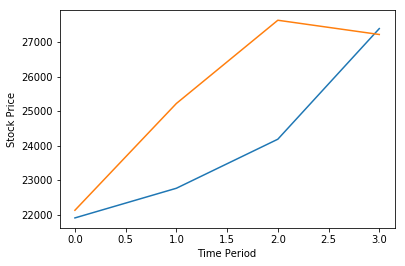

In [257]:
answer=LSTM(txs,4,'WeekNumber_Month_Season_Year' )

In [258]:
len(answer)

4

In [262]:
predict=answer[0]

In [266]:
real=answer

In [267]:
real

array([ 22126.16992188,  25220.56835938,  27632.73242188,  27219.78710938], dtype=float32)

In [268]:
rmse(predict,real)

TypeError: object of type 'numpy.float32' has no len()

In [ ]:
denormalizedTestPredictY=[item for sublist in predict for item in sublist]

In [ ]:
denormalizedTestPredictY

In [ ]:
denormalizedTestY=originalSales[train_size+seq_length:]

In [ ]:
# sales=noOutlierSales(sales)
tempxy=[list(txs['season']),list(txs['year']),list(txs['month']),list(txs['week_number']),sales]
# tempxy=[list(txs['season']),list(txs['day_of_week01']),list(txs['week_number']),sales]
xy=np.array(tempxy).transpose().astype(np.float)
originalxy=np.array(tempxy).transpose().astype(np.float)
xy=minMaxNormalizer(xy)

#data_dim은 y값 도출을 위한 feature 가지수+1(독립변수 가지수 +1(y포함))
data_dim=len(tempxy)
#data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
seq_length=5
#output_dim(=forecastDays)만큼의 다음날 y_data를 예측

output_dim=forecastDay
#hidden_dim은 정말 임의로 설정
hidden_dim=100
#learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
learning_rate=0.01
#iterations는 반복 횟수
iterations=1000
x=xy
y=xy[:,[-1]]

#build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
dataX=[]
dataY=[]
for i in range(0, len(y)-seq_length - forecastDay):
    _x=x[i:i+seq_length]
    _y = y[i + seq_length:i + seq_length + forecastDay]
    _y = np.reshape(_y, (forecastDay))
#     print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)
    train_size = int(len(dataY) * 0.7)
    
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, forecastDay])

cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn= None) 
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)
denormalizedTestY=originalSales[train_size+seq_length:]
# denormalizedTestY_original=sales[train_size+seq_length:]
denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])

targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
with tf.Session() as sess:
    #초기화
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalxy)

    # Plot predictions
    plt.plot(denormalizedTestY_feed) #실제 sales 파란색
    plt.plot(test_predict)           #예측 sales 주황색
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

In [ ]:
print(i for i in list(test_predict[-1]    ))

In [5]:
list(test_predict[  )

[17721.039]

In [6]:
denormalizedTestPredictY=[item for sublist in test_predict for item in sublist]

In [7]:
rootMeanSquaredError(denormalizedTestY,denormalizedTestPredictY)

IndexError: list index out of range

In [ ]:
len(denormalizedTestPredictY)

In [ ]:
denormalizedTestY